In [1]:
import pennylane as qml
import pennylane.numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import json

In [4]:
import vqd

In [5]:
d_observables = qml.data.Dataset()
d_observables.read('observable_results.dat')

In [6]:
# only the n_qubits value actually matters here since we're not doing optimization
# but the VQD class takes them all during instantiation
total_time = 2.0
#total_time = 0.5
dt = 0.05
max_iterations = 500
cost_threshold = 0.0001
n_qubits = 3 # this needs to be 3, however!
interface = 'autograd'

In [7]:
device_type = "qiskit.ibmq" # change this to run on real device

In [8]:
backend="ibmq_qasm_simulator"
dev = ibm_device = qml.device(device_type, wires=n_qubits, backend=backend, 
                 ibmqx_token=) #insert token string!!

In [18]:
shots = 8000 # Change this value

# extract optimized circuit parameters from simulations
results = d_observables.observable_results[shots]

# create data storage structures
observable_results = {}
observables = []
variances = []
time_vals = []
observable_results[shots] = {}

# use the VQD class
vqdrunner = vqd.VQD(interface, 
                        total_time, 
                        dt, 
                        max_iterations, 
                        cost_threshold, 
                        n_qubits, 
                        shots=shots, 
                        optimization_step_size=0.05,
                        predefined_observable_device = ibm_device)

# loop through time steps to run circuit with parameters
for a_time, params in zip(results['time'], results['final_params_v_time']):
    print(f"time :{a_time}")
    print("circuit params")
    print(params)
    
    time_vals.append(a_time)
    print('running circuits')
    observables.append(vqdrunner.qnode_three_spins_observables(params, shots=shots))
    variances.append(vqdrunner.qnode_three_spins_observables_variance(params, shots=shots))
    print('')
    
observable_results[shots]['observables'] = observables
observable_results[shots]['variances'] = variances
observable_results[shots]['time'] = time_vals
    
d_observables_on_device = qml.data.Dataset(on_device_observable_results = observable_results)
d_observables_on_device.write(f'{device_type}_{backend}_shots{shots}_observable_results.dat')

time :0.0
circuit params
[-4.44711906e-02 -4.44711906e-02 -4.44711906e-02  1.08221219e-18
  1.08221219e-18  8.13579212e-20  1.32080411e-19  8.13579212e-20
  1.08501384e-18  1.08501384e-18 -4.44711906e-02 -4.44711906e-02
 -4.44711906e-02  1.07826771e-18  1.07826771e-18  8.62663024e-20
  1.08728871e-19  8.62663024e-20]

running circuits
time :0.05
circuit params
[-0.0889302  -0.0888938  -0.0889302  -0.00018898 -0.00018898  0.00096042
  0.00192023  0.00096042 -0.0001264  -0.0001264  -0.08893009 -0.08889336
 -0.08893009 -0.00031556 -0.00031556  0.0009646   0.0019286   0.0009646 ]

running circuits
time :0.1
circuit params
[-0.13335682 -0.1331878  -0.13335682 -0.00078786 -0.00078786  0.00278134
  0.00555793  0.00278134 -0.00047898 -0.00047898 -0.13335559 -0.13318295
 -0.13335559 -0.00127332 -0.00127332  0.00280841  0.00561188  0.00280841]

running circuits
time :0.15000000000000002
circuit params
[-0.17773447 -0.17728821 -0.17773447 -0.00195369 -0.00195369  0.00531358
  0.01061013  0.005313

In [15]:
# plotting tools

In [19]:
def get_total_mag(results, shots):
    sig_x = np.tensor(results['observables'])[:,:3]
    sig_z = np.tensor(results['observables'])[:,3:]
    std_sig_x = np.sqrt(np.tensor(results['variances'])[:,:3]/shots)
    std_sig_z = np.sqrt(np.tensor(results['variances'])[:,3:]/shots)

    sum_sig_x = np.sum(sig_x, axis=1)
    sum_sig_z = np.sum(sig_z, axis=1)
    sum_sig_x_std = np.sqrt(np.sum(std_sig_x**2, axis=1))
    sum_sig_z_std = np.sqrt(np.sum(std_sig_z**2, axis=1))
    
    return sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std

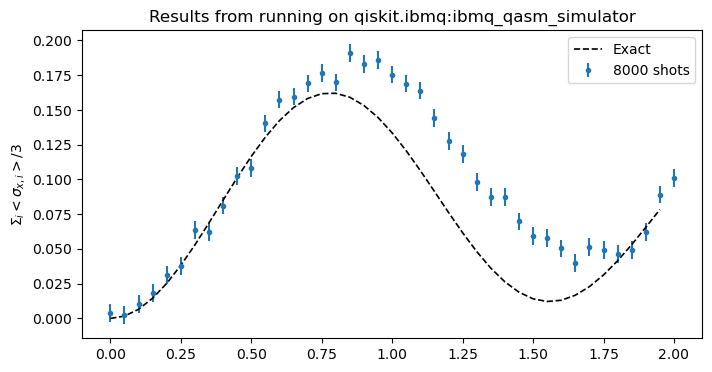

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_x/3, sum_sig_x_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{x,i}>/3$')
    
exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sx'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.set_title(f'Results from running on {device_type}:{backend}')
ax.legend()


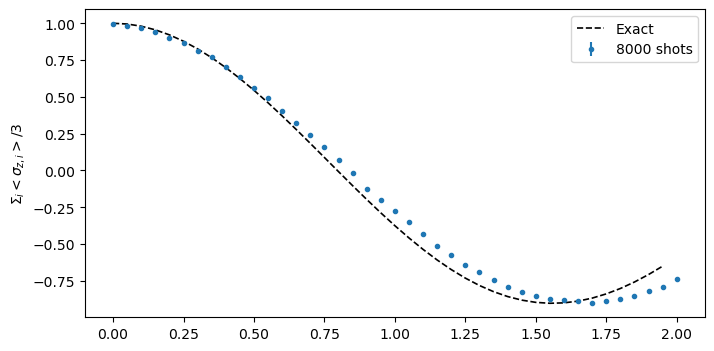

In [22]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_z/3, sum_sig_z_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{z,i}>/3$')

exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sz'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.legend()